In [1]:
import numpy as np
np.set_printoptions(suppress=True, precision=4)
import sys
import matplotlib.pyplot as plt
import sklearn.decomposition as decomp
import sklearn.linear_model as linear_model
import sklearn.datasets as sk_data
from sklearn.preprocessing import StandardScaler
import numpy.linalg as nla
import sklearn.svm as svm
import pandas as pd
from scipy.io import loadmat
from scipy.optimize import Bounds
from pymatreader import read_mat
#import test-train split
from sklearn.model_selection import train_test_split
#import Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns

In [2]:
H=pd.read_csv('/Users/inria/Desktop/M/TwinHouse.csv',sep=';',header=None)
W=pd.read_csv('/Users/inria/Desktop/M/TwinWeather.csv',sep=';',header=None)

In [3]:
# Inputs
Ti2 = H[7];    # temperature in living room at 187 cm (output)
Ti1=H[6];      # temperature in living room at 125 cm
Ti=H[5];     #temperature in living room at 67cm
Tk = H[11];   # kitchen
Td = H[12];   # doorway
Tcr = H[8];    # corridor
Tchl = H[10];  # Children room
Tb=H[13];    #Bed room
Ta = H[3];    # attic
Tg = H[4];    # cellar
Tv = H[29];   # ventilation supply air 
To = W[2];    # outdoor
Qn = W[5];    # Solar radiations from north
Qs = W[7];    # specific global solar vert. South
Qw = W[8];    # specific global solar vert. West
Qi = H[20];   # el. power living
Qk=H[23]+H[24]; #Kithcne power input minus duct losses
Qd=H[25]; #Doorway Heater
QB=H[26]; #Bedroom Heater

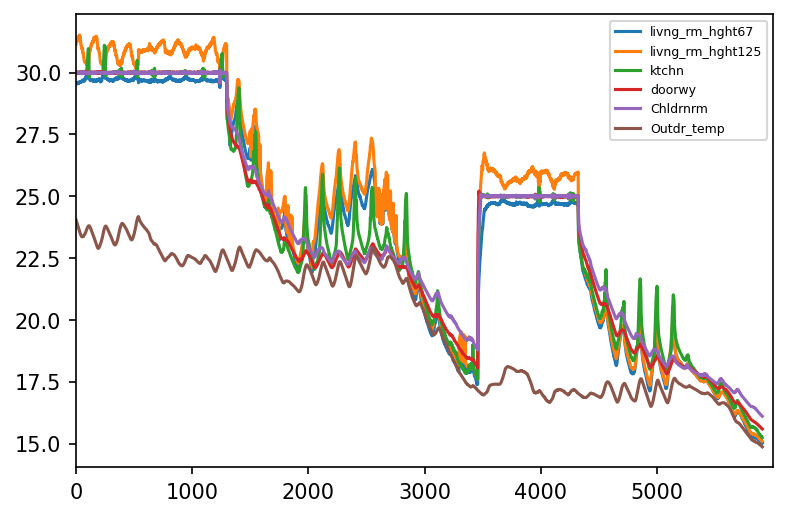

In [4]:
plt.figure(dpi=150)
plt.plot(Ti,label='livng_rm_hght67')
plt.plot(Ti2,label='livng_rm_hght125')
plt.plot(Tk,label='ktchn')
plt.plot(Td,label='doorwy')
plt.plot(Tb,label='Chldrnrm')
plt.plot(Ta,label='Outdr_temp')
#plt.axvline(x=1300,linestyle=':')
#plt.axvline(x=3500,linestyle=':')
plt.xlim(0,6000)
plt.xticks((np.arange(0,6000,1000)))
plt.legend(prop=dict(size=6))
plt.rcParams['legend.title_fontsize'] = 'xx-small'
plt.savefig('Exp_temp.png')
plt.show()

In [5]:
df=pd.DataFrame([Ti,Ti1,Ti2,Tk,Td,Tcr,Tchl,Tb]).transpose()
df['Teman']=df.mean(axis=1)
df.columns=['Lvngrm67','Lvngrm125','Lvngrm187','Ktchn','Drwy','crrdr','Chldrn_rm','Bed_rm','Tmean']
df

,Lvngrm67,Lvngrm125,Lvngrm187,Ktchn,Drwy,crrdr,Chldrn_rm,Bed_rm,Tmean
0,29.531048,29.986008,31.134912,29.986731,30.012228,30.049305,29.997070,30.000942,30.087281
1,29.547962,30.000132,31.157990,29.994390,29.999079,30.057949,30.006847,29.998449,30.095350
2,29.546320,29.972891,31.184851,30.008350,29.985352,30.067911,30.002213,30.000271,30.096020
3,29.556202,29.984280,31.223591,29.993240,30.002310,30.070709,30.000031,30.006247,30.104576
4,29.553158,29.997700,31.257040,30.005650,30.023932,30.071751,30.007252,30.000439,30.114615
...,...,...,...,...,...,...,...,...,...
5900,15.052640,15.071091,15.117129,15.262601,15.604040,15.695460,15.581810,16.120953,15.438216
5901,15.049970,15.061041,15.116321,15.260260,15.601132,15.693260,15.573151,16.118481,15.434202
5902,15.031240,15.060422,15.117849,15.256880,15.598860,15.690831,15.571490,16.113010,15.430073
5903,15.033789,15.054210,15.108339,15.253000,15.593478,15.687030,15.560300,16.107492,15.424705


In [6]:
#Generate labels for temperatures
df.insert(9,'TEMP',np.arange(0,df.shape[0],1))
for i in np.arange(0,df.shape[0],1):
    if any((0<df.iloc[i,:8])&(df.iloc[i,:8]<=26))==True:
        df.iloc[i,9]='Normal'
    if any((26<df.iloc[i,:8])&(df.iloc[i,:8]<30))==True:
        df.iloc[i,9]='Hot'
    if any(30<=(df.iloc[i,:8]))==True:
        df.iloc[i,9]='TooHot'
    


In [7]:
#Check the number of labels
import collections
counter=collections.Counter(df.iloc[:,9])
counter

Counter({'TooHot': 1297, 'Hot': 675, 'Normal': 3933})

In [8]:
#All possible combinations of number of sensors, compression and sampling
from itertools import chain, combinations,product
#s=['Lvngrm67','Lvngrm125','Lvngrm187','Ktchn','Drwy','crrdr','Chldrn_rm','Bed_rm']
s=np.arange(1,df.shape[1]-2,1)
x=list(chain(*(combinations(s,i) for i in range(1,1+len(s)))))
y=np.arange(df.shape[0],1000,-24*6*10)
z=np.arange(0,4,1)
A=[x,y,z]
M=list(product(*A))

In [9]:
M

[((1,), 5905, 0),
 ((1,), 5905, 1),
 ((1,), 5905, 2),
 ((1,), 5905, 3),
 ((1,), 4465, 0),
 ((1,), 4465, 1),
 ((1,), 4465, 2),
 ((1,), 4465, 3),
 ((1,), 3025, 0),
 ((1,), 3025, 1),
 ((1,), 3025, 2),
 ((1,), 3025, 3),
 ((1,), 1585, 0),
 ((1,), 1585, 1),
 ((1,), 1585, 2),
 ((1,), 1585, 3),
 ((2,), 5905, 0),
 ((2,), 5905, 1),
 ((2,), 5905, 2),
 ((2,), 5905, 3),
 ((2,), 4465, 0),
 ((2,), 4465, 1),
 ((2,), 4465, 2),
 ((2,), 4465, 3),
 ((2,), 3025, 0),
 ((2,), 3025, 1),
 ((2,), 3025, 2),
 ((2,), 3025, 3),
 ((2,), 1585, 0),
 ((2,), 1585, 1),
 ((2,), 1585, 2),
 ((2,), 1585, 3),
 ((3,), 5905, 0),
 ((3,), 5905, 1),
 ((3,), 5905, 2),
 ((3,), 5905, 3),
 ((3,), 4465, 0),
 ((3,), 4465, 1),
 ((3,), 4465, 2),
 ((3,), 4465, 3),
 ((3,), 3025, 0),
 ((3,), 3025, 1),
 ((3,), 3025, 2),
 ((3,), 3025, 3),
 ((3,), 1585, 0),
 ((3,), 1585, 1),
 ((3,), 1585, 2),
 ((3,), 1585, 3),
 ((4,), 5905, 0),
 ((4,), 5905, 1),
 ((4,), 5905, 2),
 ((4,), 5905, 3),
 ((4,), 4465, 0),
 ((4,), 4465, 1),
 ((4,), 4465, 2),
 ((4,), 44

In [114]:
def f_cost(i_samp):

    lmda=1 #wieght fot the # of sensors reeduction
    w1=1 #Wieght for number of sensors
    w2=1 # Weight for sampling
    w3=1 # Wieght for compression
    i=i_samp
    f_cost1=[]
    p_error1=[]
    result=[]
    df.iloc[:,:8].round(M[i][2])
    df1=df.sample(M[i][1])
    X_train,X_test,y_train,y_test=train_test_split(df1.iloc[:,list(M[i][0])],df1.TEMP,test_size=0.4,random_state=101)
    logmodel=LogisticRegression(multi_class='multinomial',solver='lbfgs',max_iter=10000)
    result=logmodel.fit(X_train,y_train)
    #Predict the new values
    predictions=logmodel.predict(X_test)
    p_error=1-metrics.f1_score(y_test,predictions,average=None)[0]
    #cost function= Probabaility(Error)-weight*delta_reduced # of sensors-weight*delta_compressed
    return w1*(8-len(M[i][0]))+w2*(5905-M[i][1])+w3*(4-M[i][2])-lmda*p_error
    #print(f_cost)

  

In [94]:
f_cost(500)

1448.9438775510205

In [95]:
lmda=1 #wieght fot the # of sensors reeduction
w1=1 #Wieght for number of sensors
w2=1 # Weight for sampling
w3=1 # Wieght for compression
i=500
f_cost1=[]
p_error1=[]
result=[]
df.iloc[:,:8].round(M[i][2])
df1=df.sample(M[i][1])
X_train,X_test,y_train,y_test=train_test_split(df1.iloc[:,list(M[i][0])],df1.TEMP,test_size=0.4,random_state=101)
logmodel=LogisticRegression(multi_class='multinomial',solver='lbfgs',max_iter=10000)
result=logmodel.fit(X_train,y_train)
#Predict the new values
predictions=logmodel.predict(X_test)
p_error=1-metrics.f1_score(y_test,predictions,average=None)[0]
#cost function= Probabaility(Error)-weight*delta_reduced # of sensors-weight*delta_compressed
f_cost1=w1*(8-len(M[i][0]))+w2*(5905-M[i][1])+w3*(4-M[i][2])-lmda*p_error
f_cost1

1448.9490616621983

In [35]:
alpha=np.repeat(1000/len(M),len(M))
alpha0=alpha

In [38]:
sum(alpha)**2

1000000.0000000071

In [118]:
epsi=1000/len(M)
epsi


0.4921259842519685

In [121]:
z=[]
import random
for i in random.sample(range(0,len(M)),2):
        deg=epsi*f_cost(i)/len(M)
        for x in range(0,len(M)):
            if x==i:
                alpha[x]=(sum(alpha)-alpha[x])/(sum(alpha)**2)
            else:
                alpha[x]=-alpha[x]/(sum(alpha)**2)
                z.append(alpha[x])
        alpha0=alpha0+deg*alpha
        alpha=alpha0    

In [123]:
z

[-0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,

In [124]:
alpha=np.repeat(1000/len(M),len(M))
alpha0=alpha
i=500
deg=epsi*f_cost(i)/len(M)
for x in range(0,len(M)):
    if x==i:
        alpha[x]=(sum(alpha)-alpha[x])/(sum(alpha)**2)
    else:
        alpha[x]=-alpha[x]/(sum(alpha)**2)
    alpha0=alpha0+deg*alpha
    alpha=alpha0    

/var/folders/0b/f9crck810477r2yg4k9mg_dc0000gp/T/ipykernel_1397/90017839.py:9: RuntimeWarning: overflow encountered in double_scalars
  alpha[x]=-alpha[x]/(sum(alpha)**2)


In [125]:
-alpha[x]/(sum(alpha)**2)

/var/folders/0b/f9crck810477r2yg4k9mg_dc0000gp/T/ipykernel_1397/2080269583.py:1: RuntimeWarning: overflow encountered in double_scalars
  -alpha[x]/(sum(alpha)**2)


0.0

In [16]:
plt.figure(figsize=(12,10))
f_cost=np.array(f_cost)
plt.plot(f_cost[0:20])
#accur=1-np.array(p_error1)
#plt.plot(accur,'--')
plt.show()

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

<Figure size 864x720 with 0 Axes>

In [ ]:
#dtype_ = np.dtype(dtype)
grad = np.array(np.gradient(M, f_cost, [[1,4,5,6,7],4000,2]))
diff = -learn_rate * grad

In [ ]:
import numpy as np
 2
 3def sgd(
 4    gradient, x, y, start, learn_rate=0.1, batch_size=1, n_iter=50,
 5    tolerance=1e-06, dtype="float64", random_state=None
 6):
 7    # Checking if the gradient is callable
 8    if not callable(gradient):
 9        raise TypeError("'gradient' must be callable")
10
11    # Setting up the data type for NumPy arrays
12    dtype_ = np.dtype(dtype)
13
14    # Converting x and y to NumPy arrays
15    x, y = np.array(x, dtype=dtype_), np.array(y, dtype=dtype_)
16    n_obs = x.shape[0]
17    if n_obs != y.shape[0]:
18        raise ValueError("'x' and 'y' lengths do not match")
19    xy = np.c_[x.reshape(n_obs, -1), y.reshape(n_obs, 1)]
20
21    # Initializing the random number generator
22    seed = None if random_state is None else int(random_state)
23    rng = np.random.default_rng(seed=seed)
24
25    # Initializing the values of the variables
26    vector = np.array(start, dtype=dtype_)
27
28    # Setting up and checking the learning rate
29    learn_rate = np.array(learn_rate, dtype=dtype_)
30    if np.any(learn_rate <= 0):
31        raise ValueError("'learn_rate' must be greater than zero")
32
33    # Setting up and checking the size of minibatches
34    batch_size = int(batch_size)
35    if not 0 < batch_size <= n_obs:
36        raise ValueError(
37            "'batch_size' must be greater than zero and less than "
38            "or equal to the number of observations"
39        )
40
41    # Setting up and checking the maximal number of iterations
42    n_iter = int(n_iter)
43    if n_iter <= 0:
44        raise ValueError("'n_iter' must be greater than zero")
45
46    # Setting up and checking the tolerance
47    tolerance = np.array(tolerance, dtype=dtype_)
48    if np.any(tolerance <= 0):
49        raise ValueError("'tolerance' must be greater than zero")
50
51    # Performing the gradient descent loop
52    for _ in range(n_iter):
53        # Shuffle x and y
54        rng.shuffle(xy)
55
56        # Performing minibatch moves
57        for start in range(0, n_obs, batch_size):
58            stop = start + batch_size
59            x_batch, y_batch = xy[start:stop, :-1], xy[start:stop, -1:]
60
61            # Recalculating the difference
62            grad = np.array(gradient(x_batch, y_batch, vector), dtype_)
63            diff = -learn_rate * grad
64
65            # Checking if the absolute difference is small enough
66            if np.all(np.abs(diff) <= tolerance):
67                break
68
69            # Updating the values of the variables
70            vector += diff
71
72    return vector if vector.shape else vector.item()

In [ ]:

w1=1 #wieght fot the # of sensors reeduction
w2=0.01 #Wieght for the number of sensors
w3=0.01 # Weight for sampling
w4=0.01 # Wieght for compression
#cost function= Probabaility(Error)-weight*delta_reduced # of sensors-weight*delta_compressed
cost=-w1*p_error+w2*len(M[i][0])+w3*M[i][1]+w4*M[i][2]
cost

In [ ]:
x=np.array(results_all)
index=pd.MultiIndex.from_product([range(s) for s in x.shape],names=['X','Y','Z'])
rs = pd.DataFrame({'x': x.flatten()}, index=index)['x']
rs = rs.unstack(level='X').swaplevel().sort_index()
rs.columns = ['Comp_1', 'Comp_2', 'Comp_3']
rs.index.names = ['Sensors','Sampling Rate']
rs.index.set_levels([ 
                       ['1','2','3','4','5','6','7','8'],['5905','4465','3025','1585']], inplace=True)


In [ ]:
rs

In [ ]:
fig,axes=plt.subplots(dpi=150)
axes.plot(rs.groupby('Sensors').mean().index,rs.groupby('Sensors').mean().Comp_3,linestyle='dashed',marker='o',color='r')
#plt.xticks(rotation=30)
plt.ylabel('F1 score')
plt.xlabel('Sensors added')
plt.savefig('sensors2.png')
plt.show()


In [ ]:
rs.groupby('Sampling Rate').mean().round(3)

In [ ]:
plt.figure(dpi=150)
rs.Comp_1.plot(linestyle='dashed',marker='o',color='red')
plt.xticks(rotation=30)
plt.show()

In [ ]:
rs.iloc[:,0]